### Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as ipw
from numpy.random import randn
import plotly.figure_factory as ff


### Simulation parameters

In [16]:
w_0 = 0.1*2*np.pi
zeta = 1/np.sqrt(2)
# np.zeroes_like - return array of zeros w. same shape and type as a given array

time_start = 0
time_end = 100
time_step = 0.05 # this gives 2000 steps

time_series = np.arange(time_start, time_end, time_step)

number_of_timesteps = len(time_series)

init_condition = np.array([2, -2])

size_of_state = 2

### Van der Pol Oscillator

In [17]:
epsilon = 2

def model(t, x):
    list = [x[1], epsilon * (1 - x[0]**2) * x[1] - x[0]]
    return np.array(list)

In [46]:
# Solve diff. equations with ODE
# similar to ODE45 in python: results = solve_ivp(obj_func, t_span, y0, t_eval = time_series)

# noise for a bit of challange
noise_sigma = 0.1

# init data containers
x = np.zeros((size_of_state, number_of_timesteps))
y = np.zeros((size_of_state, number_of_timesteps))

x[:, 0] = init_condition + np.multiply(noise_sigma, np.array(randn(size_of_state)))
y[:, 0] = model(time_start, init_condition)

for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x[:, i]

    # Sample dynamics at current time step
    y[:, i] = model(time_series[i], start_state)
    
    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    partial_trajectory = solve_ivp(model, timespan, start_state).y
    
    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))

### Free Harmonic Oscillator

In [ ]:
def model_free_harmonic_oscillator(func, t, zeta, w_0):
    """Free Harmonic Oscillator ODE (Ordinary Differential equation)"""
    pass

### Generate data for vector field and streamlines

In [47]:
lower_bound_x1 = -4
upper_bound_x1 = 4
lower_bound_x2 = -4
upper_bound_x2 = 4

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u = np.zeros(X1.shape)
v = np.zeros(X1.shape)
u_norm = np.zeros(X1.shape)
v_norm = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    # get velocities at each point
    Y_prime = model(t, np.array([value, X2[i, j]]))
    u[i] = Y_prime[0]
    v[i] = Y_prime[1]

    # normalize vector length
    V_mod = np.sqrt(u[i]**2 + v[i]**2)
    u_norm[i] = u[i] / V_mod
    v_norm[i] = v[i] / V_mod

C:\Users\Heli\AppData\Local\Temp\ipykernel_24200\3273085679.py:30: RuntimeWarning: invalid value encountered in divide
  u_norm[i] = u[i] / V_mod
C:\Users\Heli\AppData\Local\Temp\ipykernel_24200\3273085679.py:31: RuntimeWarning: invalid value encountered in divide
  v_norm[i] = v[i] / V_mod


### Plot model

(-4.0, 4.0)

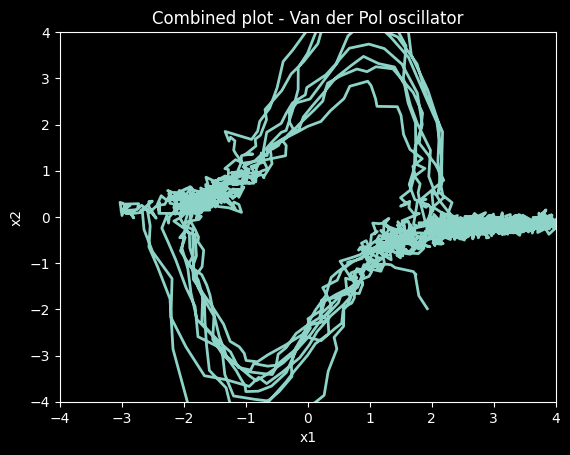

In [53]:
# Plot resulting trajectory in the data set and belonging streamlines
# Combine solution and vector field
plt.figure()
plt.title('Combined plot - Van der Pol oscillator')
 
plt.plot(x[0,:],x[1,:],'-', linewidth=2)

#ff.creastreamplot(X1, X2, u, v)
#plt.quiver(x[0,:], x[1,:], y[0,:], y[1,:])
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])

### Random Fourier Features

In [ ]:
sigma = 5
num_of_samples = 20
# ./ means right array division
w = randn(size_of_state, num_of_samples)

# func for capital_psi
def capital_psi(x_i):
    pass

### Regression

In [ ]:
# get alphas (coefficient vectors)
lamba = 0.000001 # regularization parameter

[alpha_array_rff, runtime_rff] = []

### Simulation paramters